In [1]:
## Задача: 
## Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры)
## С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv)

**Exploratory Data Analysis:**
* [Step 1. Как устроены данные](#intro)

* [Step 2. Распределение таргета](#hist_target)
* [Step 3. Exploratory Data Analysis, очистка данных и Feature engineering](#fe)
    * [1.3.1 Переменная DistrictId - идентификационный номер района](#DistrictId)
    * [1.3.2 Переменная Rooms - количество комнат](#Rooms)
    * [1.3.3 Переменная Square - площадь](#Square)
    * [1.3.4 Переменная LifeSquare - жилая площадь](#LifeSquare)
    * [1.3.5 Переменная KitchenSquare - площадь кухни](#KitchenSquare)
    * [1.3.6 Переменная Floor - этаж](#Floor)
    * [1.3.7 Переменная HouseFloor - количество этажей в доме](#Rooms)
    * [1.3.8 Переменная HouseYear - год постройки дома](#Rooms)
    * [1.3.9 Переменные Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности](#Ecology)
    * [1.3.10 Переменные Social_1, Social_2, Social_3 - социальные показатели местности](#Social)
    * [1.3.11 Переменные Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья](#Healthcare)
    * [1.3.12 Переменные Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров](#Shops)

* [Step 4. Корреляция переменных с таргетом и между собой](#corr)

* [Step 5. Построение модели и подбор гипер парметров](#model)

* [Step 6. Предсказание цен для тестового датасета](#theend)

#### Step 1. Как устроены данные <a class='anchor' id='intro'>

In [115]:
#Загрузим необходимые библиотеки для анализа данных и создадим dataframe - data:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

DATASET_NAME = 'train.csv'
data = pd.read_csv(DATASET_NAME, sep = ',')
data = data.sample(frac=1)
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1294,5368,6,3.0,78.026522,74.031304,0.0,7,17.0,2016,0.243205,B,B,5,1564,0,540.0,0,0,B,158358.903784
6195,5768,23,2.0,63.707208,NaN,1.0,17,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,149933.760059
7687,9446,11,1.0,36.692587,19.545905,7.0,7,14.0,2009,0.000170,B,B,36,5992,0,NaN,1,1,B,176073.925603
3344,12874,90,1.0,33.728782,22.372443,5.0,6,5.0,1965,0.265089,B,B,37,5288,0,1937.0,3,2,B,145764.993974
3442,11603,11,1.0,31.623337,21.910145,5.0,4,5.0,1967,0.038693,B,B,28,6533,1,1015.0,2,5,B,138976.878555


In [625]:
#Посмотрим на размерность матрицы data:
#20 признаковых описаний объектов-квартир и 10.000 наблюдений
data.shape

(10000, 20)

In [626]:
#Видим, что помимо численных переменных типа int и float, есть:
#1. Категориальные признаки Ecology_2, Ecology_3, Shops_2.
#2. Признаки с пропусками LifeSquare и Healthcare_1
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [627]:
#Посмотрим на основные статистические величины
data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


#### Step 2. Распределение таргета <a class='anchor' id='#hist_target'>

Text(0.5, 1.0, 'Распределение таргета Price')

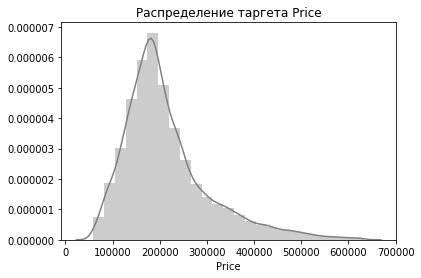

In [628]:
#Переменная Price имеет лог нормальное распределение.
#Значения переменной Price сосредоточены вокруг 200 000 руб.
#Медиана близка к среднему значению, 50% наблюдений лежит в диапазоне [153872, 249135]
#Максимум в 3 раза превышает наиболее частое значение выборки

sns.distplot(data['Price'], bins = 25, color = 'grey')
plt.title('Распределение таргета Price')

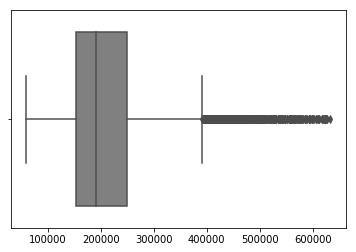

In [629]:
sns.boxplot(data['Price'].values, color = 'grey')

In [630]:
data['Price'].describe()

count     10000.000000
mean     214138.857399
std       92872.293865
min       59174.778028
25%      153872.633942
50%      192269.644879
75%      249135.462171
max      633233.466570
Name: Price, dtype: float64

#### Step 3. Exploratory Data Analysis, очистка данных и Feature engineering <a class='anchor' id='fe'>
##### 1.3.1 District - идентификационный номер района  <a class='anchor' id='DistrictId'>

Text(0.5, 1.0, 'Распределение переменной DistrictId')

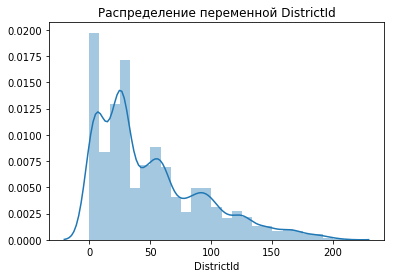

In [631]:
sns.distplot(data['DistrictId'], bins = 25)
plt.title('Распределение переменной DistrictId')

In [1034]:
#Cоздадим новую переменную на основе District:
#1. DistrictId_count - Количество предложений по указанному District
district_count = dict(data['DistrictId'].value_counts())
for n in range(0, 250):
    if district_count_train.get(n, None) == None:
        district_count_train[n] = 1

data['DistrictId_count'] = data['DistrictId'].apply(lambda x: district_count[x])

In [1014]:
#Посмотрим на корреляцию новой переменной с таргетом Price
#Видим, что чем больше предложений в районе, тем ниже цена за квартиру. Вероятно, по DistrictId квартиры можно разделить по
#признаку - квартира в спальном районе (массовая застройкой) и квартиры в центре города.
#Для этого создадим еще одну переменную: спальный район vs центр.
data.filter(items = ['DistrictId','DistrictId_count','Price']).corr()

,DistrictId,DistrictId_count,Price
DistrictId,1.000000,-0.524011,0.265100
DistrictId_count,-0.524011,1.000000,-0.378619
Price,0.265100,-0.378619,1.000000


In [1035]:
#2. District_Type - густонаселенный район/центр
def District_Type(x):
    if x >= 350:
        return 1
    else:
        return 2
data['District_Type'] = data['DistrictId_count'].apply(lambda x: District_Type(x))

In [1036]:
#3. Создадим переменные, основанные на Медиане цены за квартиру в районе
district_count_price = pd.DataFrame(data.groupby('DistrictId_count')['Price'].median())
data = pd.merge(data, data_district_count_price, on = 'DistrictId_count', how = 'left')
data.columns = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'DistrictId_count',
       'District_Type', 'District_count_price']

#4. Создадим переменные, основанные на Медиане цены за квартиру в районе
district_price = pd.DataFrame(data.groupby('DistrictId')['Price'].median())
data = pd.merge(data, district_price, on = 'DistrictId', how = 'left')
data.columns = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'DistrictId_count',
       'District_Type', 'District_count_price','District_price']

##### 1.3.2 Rooms - количество комнат <a class='anchor' id='Rooms'>

D:\Program Files (x86)\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Распределение переменной Rooms')

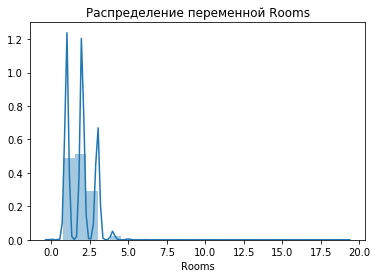

In [1019]:
#50% наблюдений лежит в узком диапазоне [1,2]
#Есть наблюдения , вероятно, с опечатками - 19 комнат
sns.distplot(data['Rooms'], bins = 25)
plt.title('Распределение переменной Rooms')

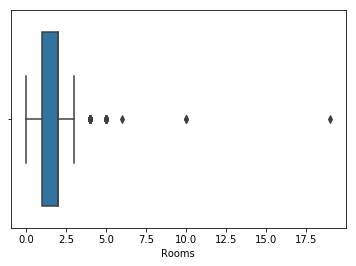

In [1020]:
sns.boxplot(data['Rooms'])

In [1021]:
#В выборке есть квартиры с нулевым количеством комнат, скорее всего это квартиры-студии, по цене они должны быть ближе к
#однушкам.
data['Rooms'].value_counts(normalize = True)

2.0     0.3880
1.0     0.3705
3.0     0.2235
4.0     0.0150
5.0     0.0018
0.0     0.0008
10.0    0.0002
19.0    0.0001
6.0     0.0001
Name: Rooms, dtype: float64

In [1037]:
#5. Rooms_Type - тип квартиры
#Создадим новую переменную "Тип квартиры" - однушка, 2x и 3x комнатные и все остальное
def rooms(x):
    if x <= 1:
        return 1
    elif x == 2:
        return 2
    elif x == 3:
        return 3
    else:
        return 4
data['Rooms_Type'] = data['Rooms'].apply(lambda x: rooms(x) )

In [1038]:
#6. Price_Rooms_Type - медиана цены по типу квартиры
Price_Rooms_Type = pd.DataFrame(data.groupby('Rooms_Type')['Price'].median())
data = pd.merge(data, Price_Rooms_Type, on = 'Rooms_Type', how = 'left')
data.columns = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'DistrictId_count',
       'District_Type', 'District_count_price', 'District_price', 'Rooms_Type',
       'Price_Rooms_Type']

In [1039]:
#7. Rooms_distrinct_type -  переменная "Тип квартиры - Местоположение дома"
data['Rooms_distrinct_type'] = None
data.loc[(data['District_Type'] == 1) & (data['Rooms_Type'] == 1), 'Rooms_distrinct_type'] = 1
data.loc[(data['District_Type'] == 1) & (data['Rooms_Type'] == 2), 'Rooms_distrinct_type'] = 2
data.loc[(data['District_Type'] == 1) & (data['Rooms_Type'] == 3), 'Rooms_distrinct_type'] = 3
data.loc[(data['District_Type'] == 1) & (data['Rooms_Type'] == 4), 'Rooms_distrinct_type'] = 4
data.loc[(data['District_Type'] == 2), 'Rooms_distrinct_type'] = 5

##### 1.3.3 Square - площадь квартиры <a class='anchor' id='Square'>

Text(0.5, 1.0, 'Распределение переменной Square')

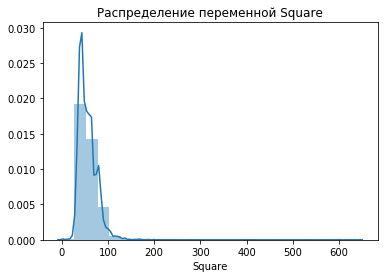

In [1027]:
#50% наблюдений лежит в узком диапазоне
#Распределение имеет хвост справа, возможно, в выборке есть загородные дома с большой площадью.
sns.distplot(data['Square'], bins = 25)
plt.title('Распределение переменной Square')

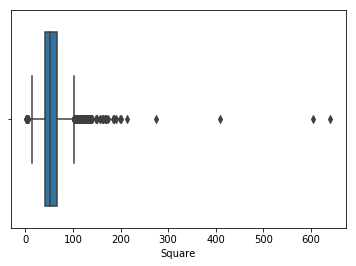

In [1028]:
sns.boxplot(data['Square'])

Text(0, 0.5, 'LifeSquare')

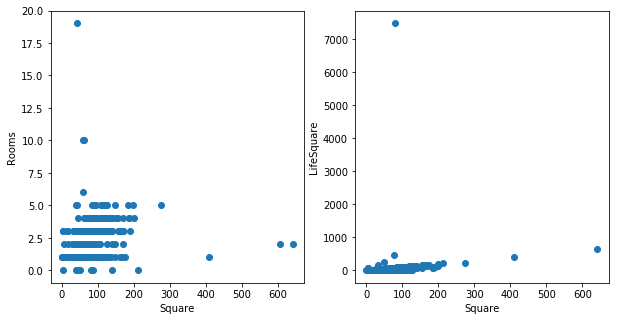

In [1029]:
#Посмотрим на зависимость Square - Rooms
#Квартиры с большим количеством комнат при небольшой площади больше похожи на опечатки, запомним идексы этих строк
#Тоже самое касается квартир с большой площадью и небольшим количеством комнат и небольшой LifeSquare - это опечатки (выбросы)
fig, ax = plt.subplots(1,2)
fig.set_size_inches(10, 5)
ax1, ax2 = ax.flatten()

ax1.scatter(data['Square'], data['Rooms'])
ax1.set_xlabel('Square')
ax1.set_ylabel('Rooms')

ax2.scatter(data['Square'], data['LifeSquare'])
ax2.set_xlabel('Square')
ax2.set_ylabel('LifeSquare')

In [1030]:
#Удалим опечатки из выборки
data[(data['Rooms'] >= 10) | (data['Square'] >= 300)].index
data = data.drop(data[(data['Rooms'] >= 10) | (data['Square'] >= 300)].index, axis = 0)

In [1040]:
#Создадим переменные "Средняя площадь в районе", "Разница между средним объявлением и квартирой"
#8.
data_square_median = pd.DataFrame(data.groupby('DistrictId').Square.median())
data = pd.merge(data, data_square_median, on = 'DistrictId', how = 'left')
data.columns = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'DistrictId_count',
       'District_Type', 'District_count_price', 'District_price', 'Rooms_Type',
       'Price_Rooms_Type', 'Rooms_distrinct_type',
       'Square_for_distinct']
#9.
data['Difference_Square'] = data['Square_for_distinct'] - data['Square']

##### 1.3.4 LifeSquare - жилая площадь  <a class='anchor' id='LifeSquare'>

D:\Program Files (x86)\Anaconda\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
D:\Program Files (x86)\Anaconda\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
D:\Program Files (x86)\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
D:\Program Files (x86)\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0.5, 1.0, 'Распределение переменной LifeSquare')

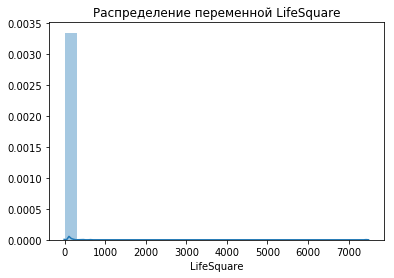

In [64]:
#Переменная имеет пропуски (2113 пропущенных значений) и 1 значение, похожее на опечатку 7480.592129. LifeSquare
#не может быть больше Square.
sns.distplot(data['LifeSquare'], bins = 25)
plt.title('Распределение переменной LifeSquare')

In [65]:
data['LifeSquare'].describe()

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64

D:\Program Files (x86)\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


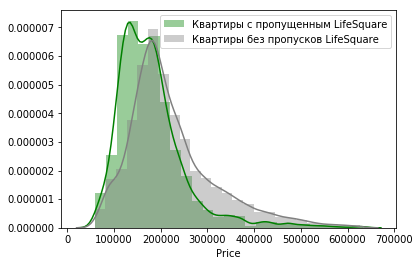

In [84]:
#Посмотрим, какую цену имеют квартиры с пропущенным LifeSquare и отличаются ли эти наблюдения от общей выборки
#Цена квартир с пропусками в LifeSquare в среднем имеют меньшую стоимость
sns.distplot(data[data['LifeSquare'].isnull()].Price, bins = 25, color = 'green', label = 'Квартиры с пропущенным LifeSquare')
sns.distplot(data[data['LifeSquare'].notnull()].Price, bins = 25, color = 'grey', label = 'Квартиры без пропусков LifeSquare')
plt.legend()

(0, 200)

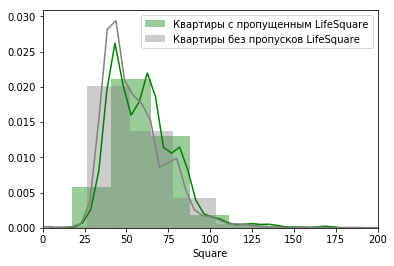

In [85]:
#По общей площади они практически совпадают
#Пропуски можно заполнить, взяв за основу среднюю долю LifeSquare от общей Square
sns.distplot(data[data['LifeSquare'].isnull()].Square, bins = 25, color = 'green', label = 'Квартиры с пропущенным LifeSquare')
sns.distplot(data[data['LifeSquare'].notnull()].Square, bins = 25, color = 'grey', label = 'Квартиры без пропусков LifeSquare')
plt.legend()
plt.xlim([0,200])

In [1043]:
#11.
proportion_ls = data['LifeSquare']/data['Square']
median = proportion_ls.median()
data['LifeSquare_wo_missing_value'] = data['LifeSquare']
index = data[data['LifeSquare'].isnull()].index
data.loc[index,'LifeSquare_wo_missing_value'] = data.loc[index,'Square'].apply(lambda x: x*median)

In [1044]:
#12. Создадим переменную доля LifeSquare к Square
data['LifeSquare_prop'] = data['LifeSquare_wo_missing_value']/data['Square']

##### 1.3.5 KitchenSquare - площадь кухни <a class='anchor' id='KitchenSquare'>

Text(0.5, 1.0, 'Распределение переменной KitchenSquare')

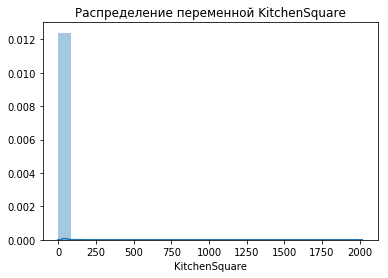

In [93]:
#2 наблюдения похожи на опечатки
sns.distplot(data['KitchenSquare'], bins = 25)
plt.title('Распределение переменной KitchenSquare')

Text(0, 0.5, 'KitchenSquare')

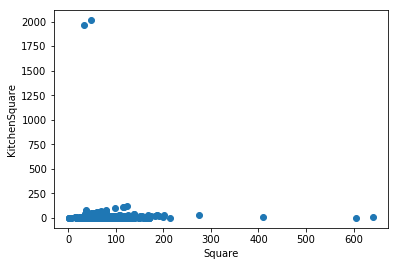

In [94]:
plt.scatter(data['Square'], data['KitchenSquare'])
plt.xlabel('Square')
plt.ylabel('KitchenSquare')

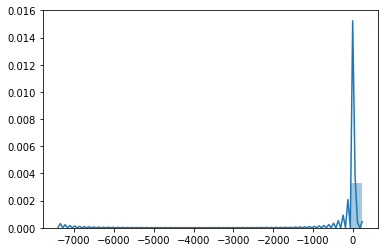

In [95]:
#Посмотрим, все ли наблюдения интерпретируемы: Square ~ LifeSquare + KitchenSquare
#864 наблюдения, у которых Общая площадь меньше, чем жилая площадь + Кухня
sns.distplot(data['Square'] - data['LifeSquare_wo_missing_value'] - data['KitchenSquare'], bins = 25)

In [96]:
difference = data['Square'] - data['LifeSquare_wo_missing_value'] - data['KitchenSquare']
(difference < 0).sum()

846

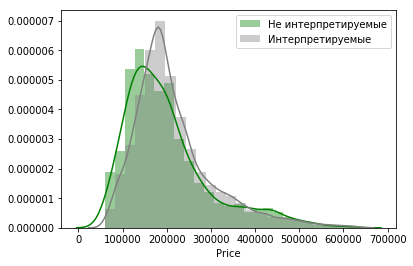

In [97]:
#Посмотрим, различается ли у них стоимость.
#У неинтерпретируемых стоимость жилья в среднем немного меньше
sns.distplot(data[(data['Square'] - data['LifeSquare_wo_missing_value'] - data['KitchenSquare']) < 0].Price, bins = 25, color = 'green', label = 'Не интерпретируемые')
sns.distplot(data[(data['Square'] - data['LifeSquare_wo_missing_value'] - data['KitchenSquare']) >= 0].Price, bins = 25, color = 'grey', label = 'Интерпретируемые')
plt.legend()

In [1045]:
#14.Создадим новую переменную "Интерпретируемость площадей квартиры"
data['Square_interpretation'] = data[(data['Square'] - data['LifeSquare_wo_missing_value'] - data['KitchenSquare']) >= 0].Id.apply(lambda x: 1)
data['Square_interpretation'] = data['Square_interpretation'].fillna(0.0)

In [1046]:
#15. Суммарные площади
data['LifeSquare_plus_Kitchen'] = data['LifeSquare_wo_missing_value'] + data['KitchenSquare']

##### 1.3.6 Floor - этаж <a class='anchor' id='Floor'>

D:\Program Files (x86)\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Распределение переменной Floor')

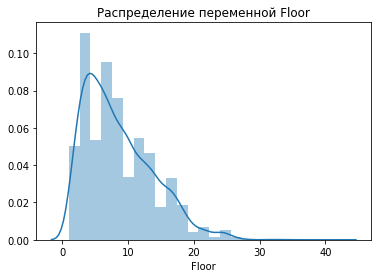

In [83]:
sns.distplot(data['Floor'], bins = 25)
plt.title('Распределение переменной Floor')

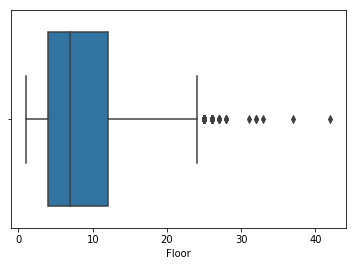

In [517]:
sns.boxplot(data['Floor'])

##### 1.3.7 HouseFloor - количество этажей в доме <a class='anchor' id='HouseFloor'>

Text(0.5, 1.0, 'Распределение переменной HouseFloor')

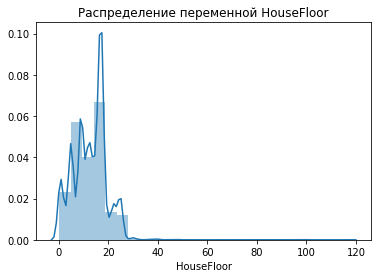

In [84]:
sns.distplot(data['HouseFloor'], bins = 25)
plt.title('Распределение переменной HouseFloor')

Text(0, 0.5, 'Floor')

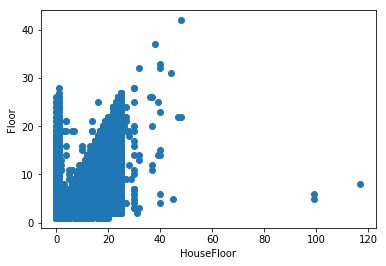

In [85]:
#Есть странные наблюдения: этажность квартиры больше, чем этажность дома...
plt.scatter(data['HouseFloor'], data['Floor'])
plt.xlabel('HouseFloor')
plt.ylabel('Floor')

In [86]:
#Сделаем несколько новых признаков, которые могут влиять на стоимость квартиры:
#15. Тип дома Многоэтажка/Средний/Пятиэтажка/Одноэтажный дом
def floor(x):
    if x == 0:
        return 0
    elif x == 1:
        return 1
    elif x >= 2 and x < 5:
        return 2
    elif x == 5:
        return 3
    elif x > 5 and x <= 8:
        return 4
    elif x == 9:
        return 5
    elif x >=10 and x < 17:
        return 6
    elif x >= 17:
        return 7
    
data['House_Type'] = data['Floor'].apply( lambda x: floor(x))

In [87]:
#16. Флаг того, что квартиры на последнем этаже
data['Flag_last_floor'] = data['HouseFloor'] - data['Floor']
data['Flag_last_floor'] = data['Flag_last_floor'].apply(lambda x: 0 if x > 0 else 1)

##### 1.3.8 HouseYear - год постройки дома <a class='anchor' id='HouseYear'>

In [748]:
#Есть 2 наблюдения с опечаткой: 20052011 и 4968, скорее всего это опечатка, можно исправить или убрать эти наблюдения

In [88]:
#16.
def house(x):
    if x == 1977:
        return 1
    if x < 2000:
        return 2
    if x >= 2000:
        return 3
    
data['House_Type_Year'] = data['HouseYear'].apply(lambda x: house(x))

In [1053]:
#17.
House_Type_Year_price = pd.DataFrame(data.groupby('House_Type_Year')['Price'].median())
data = pd.merge(data, House_Type_Year_price, on = 'House_Type_Year', how = 'left')
data.columns = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'DistrictId_count',
       'District_Type', 'District_count_price', 'District_price', 'Rooms_Type',
       'Price_Rooms_Type', 'Rooms_distrinct_type', 'Square_for_distinct',
       'Difference_Square', 'LifeSquare_wo_missing_value', 'LifeSquare_prop',
       'Square_interpretation', 'LifeSquare_plus_Kitchen', 'House_Type',
       'Flag_last_floor', 'House_Type_Year', 'House_Type_Year_price']

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price_x', 'DistrictId_count',
       'District_Type', 'District_count_price', 'District_price', 'Rooms_Type',
       'Price_Rooms_Type', 'Rooms_distrinct_type', 'Square_for_distinct',
       'Difference_Square', 'LifeSquare_wo_missing_value', 'LifeSquare_prop',
       'Square_interpretation', 'LifeSquare_plus_Kitchen', 'House_Type',
       'Flag_last_floor', 'House_Type_Year', 'Price_y'],
      dtype='object')

##### 1.3.9 Ecology  <a class='anchor' id='Ecology'>

In [1092]:
##### 1.3.9 Ecology
def ecology(x):
    if x == 'B':
        return 1
    elif x == 'A':
        return 0

data['Ecology_2'] = data['Ecology_2'].apply(lambda x: ecology(x))
data['Ecology_3'] = data['Ecology_3'].apply(lambda x: ecology(x))

##### 1.3.10 Social <a class='anchor' id='Social'>

In [1056]:
Social_1_price = pd.DataFrame(data.groupby('Social_1')['Price'].median())
data = pd.merge(data, Social_1_price, on = 'Social_1', how = 'left')
data.columns = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'DistrictId_count',
       'District_Type', 'District_count_price', 'District_price', 'Rooms_Type',
       'Price_Rooms_Type', 'Rooms_distrinct_type', 'Square_for_distinct',
       'Difference_Square', 'LifeSquare_wo_missing_value', 'LifeSquare_prop',
       'Square_interpretation', 'LifeSquare_plus_Kitchen', 'House_Type',
       'Flag_last_floor', 'House_Type_Year', 'House_Type_Year_price',
       'Social_1_price']

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price_x', 'DistrictId_count',
       'District_Type', 'District_count_price', 'District_price', 'Rooms_Type',
       'Price_Rooms_Type', 'Rooms_distrinct_type', 'Square_for_distinct',
       'Difference_Square', 'LifeSquare_wo_missing_value', 'LifeSquare_prop',
       'Square_interpretation', 'LifeSquare_plus_Kitchen', 'House_Type',
       'Flag_last_floor', 'House_Type_Year', 'House_Type_Year_price',
       'Price_y'],
      dtype='object')

##### 1.3.11 Shops  <a class='anchor' id='Shops'>

In [1119]:
data['Shops_2'] = data['Shops_2'].apply(lambda x: ecology(x))

##### 1.3.12 Healthcare  <a class='anchor' id='Healthcare'>

In [1059]:
Healthcare_2_price = pd.DataFrame(data.groupby('Helthcare_2')['Price'].median())
data = pd.merge(data, Healthcare_2_price, on = 'Helthcare_2', how = 'left')
data.columns = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'DistrictId_count',
       'District_Type', 'District_count_price', 'District_price', 'Rooms_Type',
       'Price_Rooms_Type', 'Rooms_distrinct_type', 'Square_for_distinct',
       'Difference_Square', 'LifeSquare_wo_missing_value', 'LifeSquare_prop',
       'Square_interpretation', 'LifeSquare_plus_Kitchen', 'House_Type',
       'Flag_last_floor', 'House_Type_Year', 'House_Type_Year_price',
       'Social_1_price', 'Healthcare_2_price']

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price_x', 'DistrictId_count',
       'District_Type', 'District_count_price', 'District_price', 'Rooms_Type',
       'Price_Rooms_Type', 'Rooms_distrinct_type', 'Square_for_distinct',
       'Difference_Square', 'LifeSquare_wo_missing_value', 'LifeSquare_prop',
       'Square_interpretation', 'LifeSquare_plus_Kitchen', 'House_Type',
       'Flag_last_floor', 'House_Type_Year', 'House_Type_Year_price',
       'Social_1_price', 'Price_y'],
      dtype='object')

D:\Program Files (x86)\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


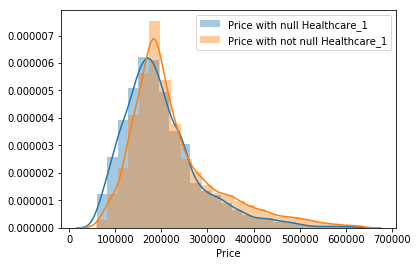

In [68]:
#Переменная с большим количеством пропусков
sns.distplot(data[data['Healthcare_1'].isna()].Price, bins = 25, label = 'Price with null Healthcare_1')
sns.distplot(data[data['Healthcare_1'] >= 0].Price, bins = 25, label = 'Price with not null Healthcare_1')
plt.legend()

In [72]:
data.loc[data[data['Healthcare_1'].isna()].index,'Healthcare_1'] = data['Healthcare_1'].median()

##### Step 4. Корреляция переменных с таргетом и между собой  <a class='anchor' id='corr'>

In [117]:
#Часть переменных удалось "усилить": например созданная переменная Social_1_price имеет корреляцию с Price на уровне
#0.425091
pd.set_option('display.max_columns', None)

corr = data.filter(items = ['Price','DistrictId', 'Rooms', 'Square', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'DistrictId_count',
       'District_Type', 'District_count_price', 'District_price', 'Rooms_Type',
       'Price_Rooms_Type', 'Rooms_distrinct_type', 'Square_for_distinct',
       'Difference_Square', 'LifeSquare_wo_missing_value', 'LifeSquare_prop',
       'Square_interpretation', 'LifeSquare_plus_Kitchen', 'House_Type',
       'Flag_last_floor', 'House_Type_Year', 'House_Type_Year_price',
       'Social_1_price', 'Healthcare_2_price']).corr()

corr.sort_values(by = ['Price'], ascending = False)

,Price,DistrictId,Rooms,Square,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,DistrictId_count,District_Type,District_count_price,District_price,Rooms_Type,Price_Rooms_Type,Rooms_distrinct_type,Square_for_distinct,Difference_Square,LifeSquare_wo_missing_value,LifeSquare_prop,Square_interpretation,LifeSquare_plus_Kitchen,House_Type,Flag_last_floor,House_Type_Year,House_Type_Year_price,Social_1_price,Healthcare_2_price
Price,1.000000,0.265110,0.570959,0.577931,0.028892,0.128899,0.088148,0.004303,-0.058446,0.022418,-0.052547,0.262984,0.238875,0.075450,0.253171,0.181159,0.070510,-0.378629,0.345781,0.520922,0.567560,0.570859,0.573441,0.381618,0.074726,-0.568466,0.093196,0.001508,0.042740,0.097456,0.110728,-0.011065,0.187474,0.214661,0.425091,0.301748
Square,0.577931,-0.027369,0.757005,1.000000,0.009036,0.116728,0.086917,-0.009856,-0.070831,0.032146,0.023718,-0.077642,-0.047936,0.022738,-0.032197,0.010947,-0.056625,0.058309,-0.050556,0.044071,0.072565,0.755395,0.756676,0.050787,0.236267,-0.948872,0.186950,0.014235,-0.029809,0.178368,0.091909,0.049133,0.043166,-0.139821,0.000830,-0.050263
Price_Rooms_Type,0.573441,0.079913,0.983383,0.756676,0.007909,-0.002514,-0.026544,-0.009680,-0.030419,-0.003016,-0.001086,0.081450,0.076676,0.012388,0.062127,0.056475,-0.002496,-0.102484,0.096751,0.145327,0.157337,0.982392,1.000000,0.209321,0.072051,-0.752660,0.149711,0.034132,0.038080,0.143074,-0.012435,0.011101,0.042120,0.079150,0.119137,0.093842
Rooms,0.570959,0.076752,1.000000,0.757005,0.004817,-0.006093,-0.032801,-0.010936,-0.031182,-0.002337,-0.006617,0.078023,0.072364,0.014126,0.064213,0.054117,-0.001062,-0.100761,0.094661,0.145855,0.157418,0.998356,0.983383,0.215099,0.069745,-0.753746,0.149778,0.034866,0.044946,0.142055,-0.014248,0.013026,0.033281,0.077442,0.116508,0.092706
Rooms_Type,0.570859,0.076058,0.998356,0.755395,0.004628,-0.005563,-0.031893,-0.011000,-0.030957,-0.002602,-0.005571,0.077581,0.071976,0.014432,0.063938,0.053746,-0.001364,-0.100744,0.094538,0.146373,0.157897,1.000000,0.982392,0.215612,0.070487,-0.751854,0.149566,0.035030,0.045005,0.141790,-0.013607,0.012701,0.033363,0.077680,0.116994,0.092810
District_price,0.567560,0.409286,0.157418,0.072565,0.030102,0.016232,-0.014392,0.020085,-0.086343,0.027359,-0.061380,0.382167,0.340553,0.128179,0.387938,0.279422,0.137425,-0.582309,0.526272,0.885016,1.000000,0.157897,0.157337,0.510044,0.244972,0.005157,-0.004036,-0.019675,0.070527,0.006755,0.004696,-0.011534,0.173295,0.347860,0.626025,0.454328
District_count_price,0.520922,0.429563,0.145855,0.044071,0.037034,0.008883,-0.034116,0.011021,-0.044324,0.003767,-0.031805,0.418293,0.367440,0.085400,0.403127,0.271419,0.138645,-0.631238,0.575174,1.000000,0.885016,0.146373,0.145327,0.557556,0.121053,-0.005875,-0.009886,-0.021376,0.077228,0.003699,-0.003069,-0.002775,0.185105,0.379555,0.614704,0.479497
Social_1_price,0.425091,0.364636,0.116508,0.000830,0.036266,-0.003709,-0.013674,-0.000556,0.098420,0.055556,-0.131951,0.574494,0.549170,0.101994,0.376588,0.361299,0.177416,-0.652448,0.617266,0.614704,0.626025,0.116994,0.119137,0.605385,-0.099064,-0.033033,-0.020831,-0.031452,0.133938,-0.006827,-0.014726,-0.032938,0.181693,0.397298,1.000000,0.548922
Rooms_distrinct_type,0.381618,0.455931,0.215099,0.050787,0.057176,-0.100215,-0.118832,0.005680,0.147869,-0.056345,-0.095736,0.642430,0.579811,0.180345,0.475937,0.430306,0.029633,-0.907170,0.965303,0.557556,0.510044,0.215612,0.209321,1.000000,-0.336944,-0.161547,-0.011219,-0.031135,0.163997,0.009501,-0.097117,-0.009517,0.223408,0.503613,0.605385,0.563353
District_Type,0.345781,0.473633,0.094661,-0.050556,0.058160,-0.105557,-0.121985,0.005884,0.155991,-0.058370,-0.099177,0.665645,0.600612,0.186599,0.491771,0.445746,0.045863,-0.938883,1.000000,0.575174,0.526272,0.094538,0.096751,0.965303,-0.351299,-0.062270,-0.038429,-0.042082,0.163089,-0.015655,-0.101246,-0.010309,0.231309,0.520740,0.617266,0.581687


In [90]:
#Переменные, которые были созданы на основе таргета. Проверим их корреляцию: корреляция низкая, при этом они имеют бОльшую
#корреляцию с таргетом, чем те переменные, которые были построены на их основе. Пример: social_1 - 0.262984, Social_1_price - 0.425091)
data.filter(items = ['Price', 'Price_Rooms_Type', 'House_Type_Year_price',
       'Social_1_price', 'Healthcare_2_price']).corr()

,Price,Price_Rooms_Type,House_Type_Year_price,Social_1_price,Healthcare_2_price
Price,1.000000,0.573441,0.214661,0.425091,0.301748
Price_Rooms_Type,0.573441,1.000000,0.079150,0.119137,0.093842
House_Type_Year_price,0.214661,0.079150,1.000000,0.397298,0.407049
Social_1_price,0.425091,0.119137,0.397298,1.000000,0.548922
Healthcare_2_price,0.301748,0.093842,0.407049,0.548922,1.000000


##### Step 5. Построение модели и подбор гиперпарметров <a class='anchor' id='model'>

In [131]:
#Построим модель RandomForestRegressor, используя все переменные: 36 переменных
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

y = pd.DataFrame(data['Price'])
X = data.filter(items = ['DistrictId', 'Rooms', 'Square', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'DistrictId_count',
       'District_Type', 'District_count_price', 'District_price', 'Rooms_Type',
       'Price_Rooms_Type', 'Rooms_distrinct_type', 'Square_for_distinct',
       'Difference_Square', 'LifeSquare_wo_missing_value', 'LifeSquare_prop',
       'Square_interpretation', 'LifeSquare_plus_Kitchen', 'House_Type',
       'Flag_last_floor', 'House_Type_Year', 'House_Type_Year_price',
       'Social_1_price', 'Healthcare_2_price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_predicted = rfr.predict(X_test)
r2_score(y_predicted, y_test)

D:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Program Files (x86)\Anaconda\lib\site-packages\ipykernel_launcher.py:20: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.5559796336112802

D:\Program Files (x86)\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Распределение остаткой модели')

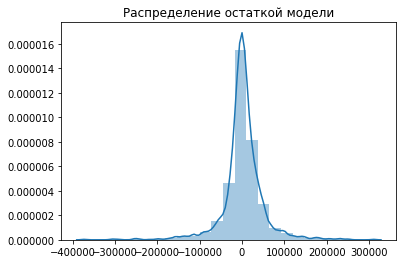

In [120]:
#Распределение остатков
e = y_test['Price'].values - y_predicted
sns.distplot(e, bins = 25)
plt.title('Распределение остаткой модели')

In [121]:
#Построим модель RandomForestRegressor, используя минимальный набор переменных, значимо не снижая качество модели по показателю 
#r_2.
#Уменьшили в 2 раза количество переменных, не потеряв в значимости.
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

y = pd.DataFrame(data['Price'])
X = data.filter(items = ['DistrictId','District_price',
                                      'Price_Rooms_Type',
                                      'Square',
                                      'KitchenSquare',
                                      'LifeSquare_wo_missing_value',
                                      'Floor', 
                                      'HouseFloor',
                                      'HouseYear',
                                      'House_Type',
                                      'House_Type_Year',
                                      'Social_1', 'Social_2', 'Social_3',
                                      'Helthcare_2',
                                      'Shops_1', 'Shops_2', 'Social_1_price','Healthcare_2_price'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_predicted = rfr.predict(X_test)
r2_score(y_predicted, y_test)

D:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\Program Files (x86)\Anaconda\lib\site-packages\ipykernel_launcher.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.6132711469274708

In [122]:
#Построим модель GradientBoostingRegressor:
from sklearn.ensemble import GradientBoostingRegressor
y = pd.DataFrame(data['Price'])
X = pd.DataFrame(data.filter(items = ['DistrictId','District_price',
                                      'Price_Rooms_Type',
                                      'Square',
                                      'KitchenSquare',
                                      'LifeSquare_wo_missing_value',
                                      'Floor', 
                                      'HouseFloor',
                                      'HouseYear',
                                      'House_Type' ,
                                      'House_Type_Year',
                                      'Social_1', 'Social_2', 'Social_3',
                                      'Helthcare_2',
                                      'Shops_1', 'Shops_2', 'Social_1_price','Healthcare_2_price']))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

xgb = GradientBoostingRegressor()
xgb.fit(X_train, y_train)
y_predicted = xgb.predict(X_test)
r2_score(y_predicted, y_test)

D:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6176421610755922

D:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

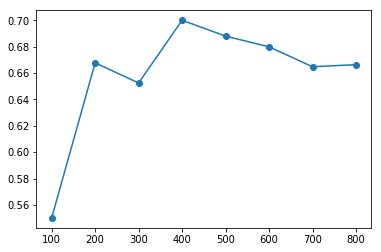

In [123]:
#Попробуем увеличить значимость, подобрав гиперпараметры: n_estimator, max_depth, min_samples_leaf:
n_estimators_list = [100, 200, 300, 400, 500, 600, 700, 800]
r2_score_list = []
for n in n_estimators_list:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = n)
    xgb = GradientBoostingRegressor(n_estimators = n)
    xgb.fit(X_train, y_train)
    y_predicted = xgb.predict(X_test)
    r2 = r2_score(y_predicted, y_test)
    r2_score_list.append(r2)
plt.plot(n_estimators_list, r2_score_list, marker = 'o')

D:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

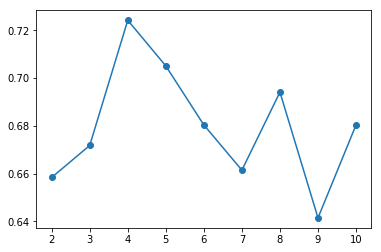

In [124]:
max_depth_list = [2, 3, 4, 5, 6, 7, 8, 9, 10]
r2_score_list = []
for n in max_depth_list:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = n)
    xgb = GradientBoostingRegressor(n_estimators = 400, max_depth = n)
    xgb.fit(X_train, y_train)
    y_predicted = xgb.predict(X_test)
    r2 = r2_score(y_predicted, y_test)
    r2_score_list.append(r2)
plt.plot(max_depth_list, r2_score_list, marker = 'o')

D:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

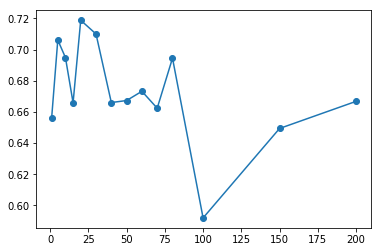

In [125]:
min_samples_leaf_list = [1, 5, 10, 15, 20, 30, 40, 50, 60 ,70, 80, 100, 150, 200]
r2_score_list = []
for n in min_samples_leaf_list:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = n)
    xgb = GradientBoostingRegressor(n_estimators = 400, max_depth = 4, min_samples_leaf = n)
    xgb.fit(X_train, y_train)
    y_predicted = xgb.predict(X_test)
    r2 = r2_score(y_predicted, y_test)
    r2_score_list.append(r2)
plt.plot(min_samples_leaf_list, r2_score_list, marker = 'o')

In [130]:
#Итоговое качество модели с подбором гиперпараметров:
from sklearn.ensemble import GradientBoostingRegressor
y = pd.DataFrame(data['Price'])
X = pd.DataFrame(data.filter(items = ['DistrictId','District_price',
                                      'Price_Rooms_Type'
                                      'Square',
                                      'KitchenSquare',
                                      'LifeSquare_wo_missing_value',
                                      'Floor', 
                                      'HouseFloor',
                                      'HouseYear',
                                      'House_Type' ,
                                      'House_Type_Year',
                                      'Social_1', 'Social_2', 'Social_3',
                                      'Helthcare_2',
                                      'Shops_1', 'Shops_2', 'Social_1_price','Healthcare_2_price']))


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 150)

xgb = GradientBoostingRegressor(n_estimators = 700, max_depth = 5, min_samples_leaf = 10)
xgb.fit(X_train, y_train)
y_predicted_test = xgb.predict(X_test)
r2_score(y_predicted_test, y_test)

D:\Program Files (x86)\Anaconda\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5822652403982276

In [27]:
#Предобработаем данные на test и сделаем прогноз:
data_test = pd.read_csv('test.csv', sep = ',')
data_test = data_test.merge(data.filter(items = ['DistrictId','District_price']).drop_duplicates(), on = 'DistrictId', how = 'left')
data_test.loc[data_test[data_test['District_price'].isna()].index, 'District_price'] = data[data['DistrictId'] >= 194].District_price.median()
data_test['Rooms_Type'] = data_test['Rooms'].apply(lambda x: rooms(x))
data_test = data_test.merge(data.filter(items = ['Rooms_Type','Price_Rooms_Type']).drop_duplicates(), on = 'Rooms_Type', how = 'left')
data_test['LifeSquare_wo_missing_value'] = data_test['LifeSquare']
index = data_test[data_test['LifeSquare'].isnull()].index
data_test.loc[index,'LifeSquare_wo_missing_value'] = data_test.loc[index,'Square'].apply(lambda x: x*median)
data_test['House_Type'] = data_test['Floor'].apply( lambda x: floor(x))
data_test['House_Type_Year'] = data_test['HouseYear'].apply(lambda x: house(x))
data_test['Shops_2'] = data_test['Shops_2'].apply(lambda x: ecology(x))
data_test = data_test.merge(data.filter(items = ['Social_1','Social_1_price']).drop_duplicates(), on = 'Social_1', how = 'left')
data_test = data_test.merge(data.filter(items = ['Helthcare_2','Healthcare_2_price']).drop_duplicates(), on = 'Helthcare_2', how = 'left')

In [28]:
X_test = pd.DataFrame(data_test.filter(items = ['DistrictId','District_price',
                                      'Price_Rooms_Type',
                                      'Square',
                                      'KitchenSquare',
                                      'LifeSquare_wo_missing_value',
                                      'Floor', 
                                      'HouseFloor',
                                      'HouseYear',
                                      'House_Type' ,
                                      'House_Type_Year',
                                      'Social_1', 'Social_2', 'Social_3',
                                      'Helthcare_2',
                                      'Shops_1', 'Shops_2', 'Social_1_price','Healthcare_2_price']))
y_predicted = xgb.predict(X_test)

In [135]:
y_predicted = pd.DataFrame(y_predicted)
y_predicted.to_csv('y_predicted.csv')

<Figure size 2160x720 with 0 Axes>

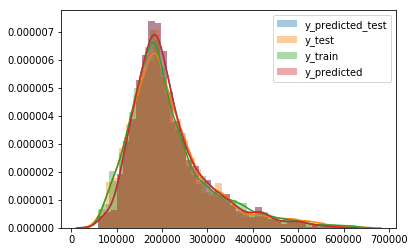

<Figure size 2160x720 with 0 Axes>

In [36]:
#Посмотрим на распределение y_predicted_test и y_predicted
sns.distplot(y_predicted_test, label = 'y_predicted_test')
sns.distplot(y_test, label = 'y_test')
sns.distplot(y_train, label = 'y_train')
sns.distplot(y_predicted, label = 'y_predicted')
plt.legend()
plt.figure(figsize = (30,10))

In [ ]:
#Вспомогательные функции: new_features(data)

#Создание 22 новых переменных, используя комбинацию существующих признаков:

#1. DistrictId_count - Количество предложений по указанному District
def new_features(data):
    district_count = dict(data['DistrictId'].value_counts())
    for n in range(0, 250):
        if district_count.get(n, None) == None:
            district_count[n] = 1

    data['DistrictId_count'] = data['DistrictId'].apply(lambda x: district_count[x])

    #2. District_Type - густонаселенный район/центр
    def District_Type(x):
        if x >= 350:
            return 1
        else:
            return 2
    data['District_Type'] = data['DistrictId_count'].apply(lambda x: District_Type(x)) 

    #3. Переменная District_count_price, основанная на Медиане цены за квартиру в районе
    district_count_price = pd.DataFrame(data.groupby('DistrictId_count')['Price'].median())
    data = pd.merge(data, district_count_price, on = 'DistrictId_count', how = 'left')
    data.columns = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
           'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
           'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
           'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'DistrictId_count',
           'District_Type', 'District_count_price']

    #4. Переменная District_price, основанная на Медиане цены за квартиру в районе
    district_price = pd.DataFrame(data.groupby('DistrictId')['Price'].median())
    data = pd.merge(data, district_price, on = 'DistrictId', how = 'left')
    data.columns = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
           'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
           'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
           'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'DistrictId_count',
           'District_Type', 'District_count_price','District_price']

    #5. Rooms_Type - тип квартиры
    data.loc[data['Rooms'] == 0, 'Rooms'] = 1
    def rooms(x):
        if x <= 1:
            return 1
        elif x == 2:
            return 2
        elif x == 3:
            return 3
        else:
            return 4
    data['Rooms_Type'] = data['Rooms'].apply(lambda x: rooms(x))

    #6. Price_Rooms_Type - медиана цены за квартиру по типу квартиры
    Price_Rooms_Type = pd.DataFrame(data.groupby('Rooms_Type')['Price'].median())
    data = pd.merge(data, Price_Rooms_Type, on = 'Rooms_Type', how = 'left')
    data.columns = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
    'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
    'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
    'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'DistrictId_count',
    'District_Type', 'District_count_price', 'District_price', 'Rooms_Type',
    'Price_Rooms_Type']


    #7. Rooms_distrinct_type -  переменная "Тип квартиры - Местоположение дома"
    data['Rooms_distrinct_type'] = None
    data.loc[(data['District_Type'] == 1) & (data['Rooms_Type'] == 1), 'Rooms_distrinct_type'] = 1
    data.loc[(data['District_Type'] == 1) & (data['Rooms_Type'] == 2), 'Rooms_distrinct_type'] = 2
    data.loc[(data['District_Type'] == 1) & (data['Rooms_Type'] == 3), 'Rooms_distrinct_type'] = 3
    data.loc[(data['District_Type'] == 1) & (data['Rooms_Type'] == 4), 'Rooms_distrinct_type'] = 4
    data.loc[(data['District_Type'] == 2), 'Rooms_distrinct_type'] = 5


    #8. Опечатки
    data = data.drop(data[(data['Rooms'] >= 10) | (data['Square'] >= 300)].index, axis = 0)

    #9."Средняя площадь в районе"
    data_square_median = pd.DataFrame(data.groupby('DistrictId').Square.median())
    data = pd.merge(data, data_square_median, on = 'DistrictId', how = 'left')
    data.columns = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
           'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
           'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
           'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'DistrictId_count',
           'District_Type', 'District_count_price', 'District_price', 'Rooms_Type',
           'Price_Rooms_Type', 'Rooms_distrinct_type',
           'Square_for_distinct']
    #10. Разница между средним объявлением и квартирой"
    data['Difference_Square'] = data['Square_for_distinct'] - data['Square']

    #11. LifeSquare без пропусков
    proportion_ls = data['LifeSquare']/data['Square']
    median = proportion_ls.median()
    data['LifeSquare_wo_missing_value'] = data['LifeSquare']
    index = data[data['LifeSquare'].isnull()].index
    data.loc[index,'LifeSquare_wo_missing_value'] = data.loc[index,'Square'].apply(lambda x: x*median)

    #12. Создадим переменную доля LifeSquare к Square
    data['LifeSquare_prop'] = data['LifeSquare_wo_missing_value']/data['Square']

    #13. Интерпретируемость площадей кваритры
    data['Square_interpretation'] = data[(data['Square'] - data['LifeSquare_wo_missing_value'] - data['KitchenSquare']) >= 0].Id.apply(lambda x: 1)
    data['Square_interpretation'] = data['Square_interpretation'].fillna(0.0)

    #14. Суммарные площади
    data['LifeSquare_plus_Kitchen'] = data['LifeSquare_wo_missing_value'] + data['KitchenSquare']

    #15. Тип дома (этажность)
    def floor(x):
        if x == 0:
            return 0
        elif x == 1:
            return 1
        elif x >= 2 and x < 5:
            return 2
        elif x == 5:
            return 3
        elif x > 5 and x <= 8:
            return 4
        elif x == 9:
            return 5
        elif x >=10 and x < 17:
            return 6
        elif x >= 17:
            return 7

    data['House_Type'] = data['Floor'].apply( lambda x: floor(x))

    #16. Флаг того, что квартира на последнем этаже
    data['Flag_last_floor'] = data['HouseFloor'] - data['Floor']
    data['Flag_last_floor'] = data['Flag_last_floor'].apply(lambda x: 0 if x > 0 else 1)

    #17. Тип дома: новые постройки vs старые
    def house(x):
        if x == 1977:
            return 1
        if x < 2000:
            return 2
        if x >= 2000:
            return 3

    data['House_Type_Year'] = data['HouseYear'].apply(lambda x: house(x))

    #18. Связка Тип дома - медиана цены
    House_Type_Year_price = pd.DataFrame(data.groupby('House_Type_Year')['Price'].median())
    data = pd.merge(data, House_Type_Year_price, on = 'House_Type_Year', how = 'left')
    data.columns = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'DistrictId_count',
       'District_Type', 'District_count_price', 'District_price', 'Rooms_Type',
       'Price_Rooms_Type', 'Rooms_distrinct_type', 'Square_for_distinct',
       'Difference_Square', 'LifeSquare_wo_missing_value', 'LifeSquare_prop',
       'Square_interpretation', 'LifeSquare_plus_Kitchen', 'House_Type',
       'Flag_last_floor', 'House_Type_Year', 'House_Type_Year_price']

    #19.
    def ecology(x):
        if x == 'B':
            return 1
        elif x == 'A':
            return 0

    data['Ecology_2'] = data['Ecology_2'].apply(lambda x: ecology(x))
    data['Ecology_3'] = data['Ecology_3'].apply(lambda x: ecology(x))

    #20. Связка социальные показатели - медиана цены
    Social_1_price = pd.DataFrame(data.groupby('Social_1')['Price'].median())
    data = pd.merge(data, Social_1_price, on = 'Social_1', how = 'left')
    data.columns = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'DistrictId_count',
       'District_Type', 'District_count_price', 'District_price', 'Rooms_Type',
       'Price_Rooms_Type', 'Rooms_distrinct_type', 'Square_for_distinct',
       'Difference_Square', 'LifeSquare_wo_missing_value', 'LifeSquare_prop',
       'Square_interpretation', 'LifeSquare_plus_Kitchen', 'House_Type',
       'Flag_last_floor', 'House_Type_Year', 'House_Type_Year_price',
       'Social_1_price']

    #21.
    data['Shops_2'] = data['Shops_2'].apply(lambda x: ecology(x))

    #22. Связка показатели местности - средняя медиана цены
    Healthcare_2_price = pd.DataFrame(data.groupby('Helthcare_2')['Price'].median())
    data = pd.merge(data, Healthcare_2_price, on = 'Helthcare_2', how = 'left')
    data.columns = ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price', 'DistrictId_count',
       'District_Type', 'District_count_price', 'District_price', 'Rooms_Type',
       'Price_Rooms_Type', 'Rooms_distrinct_type', 'Square_for_distinct',
       'Difference_Square', 'LifeSquare_wo_missing_value', 'LifeSquare_prop',
       'Square_interpretation', 'LifeSquare_plus_Kitchen', 'House_Type',
       'Flag_last_floor', 'House_Type_Year', 'House_Type_Year_price',
       'Social_1_price', 'Healthcare_2_price']
    return data